# Wavelet states

In [1]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import plotly.express as px 
import plotly.graph_objects as go 
import concurrent.futures
import gc
from kneed import KneeLocator

from one.api import ONE

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//4_analyses/4_Clustering//'
os.chdir(functions_path)
from clustering_functions import GMM_neg_log_likelihood
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from postprocessing_functions import remove_states_str, state_identifiability, align_bin_design_matrix, states_per_trial_phase, broader_label
from plotting_functions import plot_avg_state, wheel_over_wavelet_clusters, plot_states_aligned
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log

one = ONE(mode='remote')

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/alf/files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(


ModuleNotFoundError: No module named 'plotting_functions'

## Parameters

In [3]:
# Parameters
bin_size = 0.017
multiplier=1
num_states = 2
num_train_batches = 5
event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue'] 

# LOAD DATA
cv_results_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
data_path ='/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
grid_search_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/grid_search/individual_sessions/'

all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

use_sets = [['avg_wheel_vel'], ['whisker_me'], ['Lick count'], ['0.5',
    '1.0', '2.0', '4.0', '8.0']]
var_interest_map = ['avg_wheel_vel', 'whisker_me', 'Lick count', 'wavelet']
idx_init_list = [0, 1, 2, 4]
idx_end_list = [1, 2, 3, 9]

var_interest = 'wavelet'

optimal_k = 3

In [ ]:
# Identify sessions availableto process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    sessions_to_process.append((mouse_name, session))

In [ ]:
optimal_k = 4

In [6]:
def plot_mean_cluster(cluster_features, plt_vars):
    plt.rcParams.update({'font.size': 16})

    # Get viridis color palette
    unique_clusters = cluster_features['most_likely_states'].unique()
    colors = sns.color_palette("viridis", len(unique_clusters)).as_hex()  # Get hex colors

    # Create the figure
    fig = go.Figure()

    for i, cluster in enumerate(unique_clusters):
        fig.add_trace(go.Scatterpolar(
            r=np.array(cluster_features.loc[cluster_features['most_likely_states'] == cluster, plt_vars])[0],
            theta=plt_vars,
            fill='toself',
            name=f'Wavelet transform cluster {cluster}',
            line=dict(color=colors[i])  # Assign Viridis color
        ))

    fig.update_layout(
        polar=dict(
            angularaxis=dict(
                tickfont=dict(size=16)  # Set the font size of the theta labels
            ),
            radialaxis=dict(
                visible=True,
                tickfont=dict(size=16)
            )
        ),
        showlegend=True
    )

    fig.show()

In [8]:
all_cluster_features = pd.DataFrame(columns=['mouse_name', 'session', 'most_likely_states', 'abs_wheel_vel', '0.5', 
                                                                                            '1.0', '2.0', '4.0', '8.0'])
index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
idx_init = idx_init_list[index_var]
idx_end = idx_end_list[index_var]
var_names = use_sets[index_var]

for m, mat in enumerate(sessions_to_process[:1]):

    mouse_name = mat[0]
    session = mat[1]
    fit_id = str(mouse_name+session)

    # Get session data
    filename = data_path + "session_trials_" + str(session) + '_'  + mouse_name
    session_trials = pd.read_parquet(filename, engine='pyarrow').reset_index()  # I think resetting index is what gives the trial number?
    # Get design_matrix
    filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
    unnorm_design_matrix =  pd.read_parquet(filename, engine='pyarrow').dropna().reset_index()
    # Get session data
    filename = data_path + "standardized_design_matrix_" + str(session) + '_'  + mouse_name
    standardized_designmatrix = np.load(filename+str('.npy'))
    filtered_matrix = standardized_designmatrix[~np.isnan(standardized_designmatrix).any(axis=1)]  # Need to dropnans
    # design_matrix = np.abs(filtered_matrix.copy()[:, idx_init:idx_end])
    design_matrix = filtered_matrix.copy()[:, idx_init:idx_end]
    num_timesteps = np.shape(design_matrix)[0]
    data = design_matrix[:(num_timesteps // num_train_batches) * num_train_batches]

    """ Load wavelet states """
    # Save most_likely_states
    states_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/wavelet_transform_states/'
    states = pickle.load(open(states_results_path + "most_likely_states" + '_'+str(optimal_k)+'_'+ fit_id, "rb"))
    
    " Prepare data "
    num_timesteps = np.shape(design_matrix)[0]
    use_var = ['avg_wheel_vel', '0.5', '1.0', '2.0', '4.0', '8.0']
    design_matrix_heading = pd.DataFrame(columns=use_var)
    design_matrix_heading[var_names] = design_matrix[0:len(states)]  # TODO: need to understand why number is the same and whether it depends on lag
    bins = unnorm_design_matrix[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
    design_matrix_heading['Bin'] = bins
    design_matrix_heading['avg_wheel_vel'] = filtered_matrix[:len(data), 0]

    # Align bins
    init = -1 * multiplier
    end = 1.5 * multiplier
    empirical_data = align_bin_design_matrix(init, end, event_type_list, session_trials, design_matrix_heading, states, multiplier)
    # empirical_data = empirical_data.drop(columns=['new_bin'])
    # empirical_data['identifiable_states'] = identifiable_states
    
    """ Trial types """
    # Split in trial types
    states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
    states_trial['mouse_name'] = mouse_name
    states_trial['session'] = session
    states_trial = broader_label(states_trial)
    
    # # Plot raw trace over states       
    # init = 400
    # inter = 1000
    # wheel_over_wavelet_clusters(init, inter, empirical_data, session_trials)
    # print(session)
    
    # Plot states statistics
    use_df = unnorm_design_matrix[:(num_timesteps // num_train_batches) * num_train_batches]
    bins = use_df[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
    use_df['Bin'] = bins
    use_df['avg_wheel_vel'] = filtered_matrix[:len(data), 0]

    # Align bins
    init = -1 * multiplier
    end = 1.5 * multiplier
    empirical_data2 = align_bin_design_matrix(init, end, event_type_list, session_trials, use_df, states, multiplier)
    empirical_data2['abs_wheel_vel'] = np.abs(empirical_data2['avg_wheel_vel'])

    cluster_features = pd.DataFrame(empirical_data2.groupby(['most_likely_states'])['abs_wheel_vel', '0.5', 
                                                                                            '1.0', '2.0', '4.0', '8.0'].mean()).reset_index()
    # Save to big data frame with all animals
    cluster_features['mouse_name'] = mouse_name
    cluster_features['session'] = session    
    all_cluster_features = all_cluster_features.append(cluster_features)
    
    # plt_vars = ['0.5', '1.0', '2.0', '4.0', '8.0']
    # plot_mean_cluster(cluster_features, plt_vars)
    # sns.barplot(x='most_likely_states', y='abs_wheel_vel', data=cluster_features)

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learni

ValueError: Cannot subset columns with a tuple with more than one element. Use a list instead.

In [29]:
# Save all cluster features
file_to_save = all_cluster_features.copy()
filename = 'all_cluster_features'
save_path = '/home/ines/repositories/representation_learning_variability/Models/Maths intuitions/Wavelets/'
file_format = 'parquet'
script_name = 'states.ipynb'
metadata = save_and_log(file_to_save, filename, file_format, save_path, script_name)

# Load instead

In [4]:
# Load preprocessed data
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/Wavelets/'
filename = str(results_path + 'all_cluster_features02-18-2025')
all_cluster_features = pd.read_parquet(filename, engine='pyarrow')

In [5]:
melted_df = pd.melt(all_cluster_features, id_vars=['session', 'most_likely_states'], value_vars=['0.5', '1.0', '2.0', '4.0', '8.0'])

In [6]:
wheel_mapping = {1:0, 2:1, 3:2, 0:3}

replace_wheel = np.vectorize(wheel_mapping.get)
melted_df['most_likely_states'] = replace_wheel(melted_df['most_likely_states'])
melted_df = melted_df.rename(columns={"variable": "Frequency"})
melted_df = melted_df.rename(columns={"most_likely_states": "Wheel"})

In [7]:
from matplotlib.colors import LinearSegmentedColormap

# Load color palette
colors = sns.cubehelix_palette(3,as_cmap=False)
colors = sns.color_palette("viridis", 4)

# Function to create a colormap from a base color (white to color)
def create_shaded_cmap(base_color, name='custom_cmap'):
    cdict = {
        'red':   [[0.0, 1.0, 1.0], [1.0, base_color[0], base_color[0]]],
        'green': [[0.0, 1.0, 1.0], [1.0, base_color[1], base_color[1]]],
        'blue':  [[0.0, 1.0, 1.0], [1.0, base_color[2], base_color[2]]]
    }
    return LinearSegmentedColormap(name, cdict)

/tmp/ipykernel_32712/493285950.py:4: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:grey_r'` for the same effect.

  sns.barplot(x='Frequency', y='value', data=melted_df, color='grey_r', hue='Wheel', alpha=0.5)


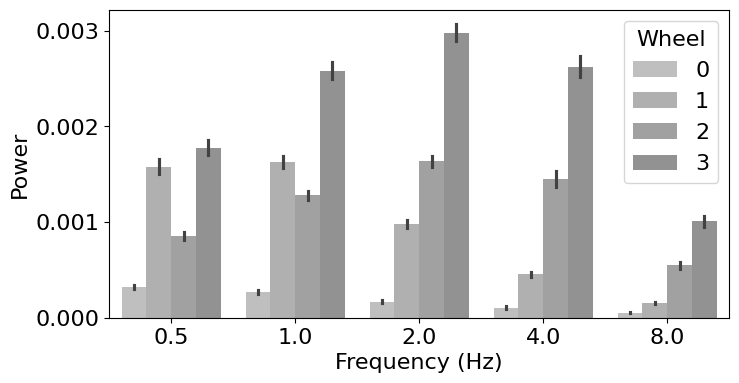

In [9]:
plt.figure(figsize=(8, 4))
# colors = sns.color_palette("viridis", 4)

sns.barplot(x='Frequency', y='value', data=melted_df, color='grey_r', hue='Wheel', alpha=0.5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')


plt.rcParams.update({'font.size': 16})
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


/tmp/ipykernel_11647/4200247944.py:4: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:grey'` for the same effect.

  sns.barplot(x='most_likely_states', y='value', data=melted_df, color='grey', hue='Frequency', alpha=0.5)


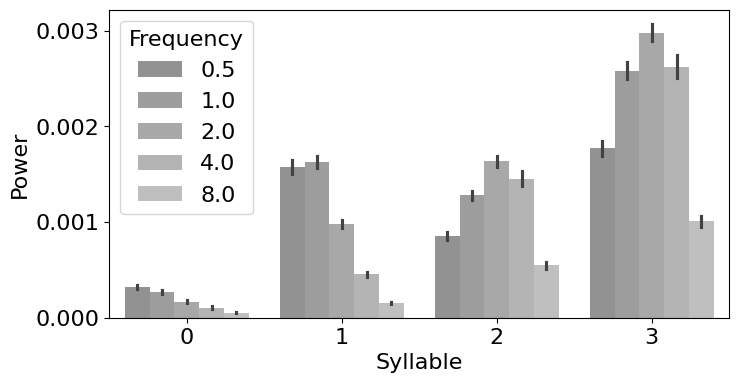

In [12]:
plt.figure(figsize=(8, 4))
# colors = sns.color_palette("viridis", 4)

sns.barplot(x='most_likely_states', y='value', data=melted_df, color='grey', hue='Frequency', alpha=0.5)
plt.xlabel('Syllable')
plt.ylabel('Power')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


In [21]:
use_df = all_cluster_features[['session', 'abs_wheel_vel']]
use_df = all_cluster_features.copy()
sorted_df = use_df.sort_values(by=['session', 'abs_wheel_vel'], ascending=[True, True], na_position='last').reset_index()
sorted_df['index'] = sorted_df.groupby('session').cumcount()

In [22]:
melted_df = pd.melt(sorted_df, id_vars=['session', 'index'], value_vars=['0.5', '1.0', '2.0', '4.0', '8.0'])

In [23]:
sns.barplot(x='index', y='value', data=melted_df, x='variable', units='session', estimator=None, alpha=0.5)

,session,index,variable,value
0,03063955-2523-47bd-ae57-f7489dd40f15,0,0.5,0.000372
1,03063955-2523-47bd-ae57-f7489dd40f15,1,0.5,0.001358
2,03063955-2523-47bd-ae57-f7489dd40f15,2,0.5,0.000739
3,03063955-2523-47bd-ae57-f7489dd40f15,3,0.5,0.001689
4,032452e9-1886-449d-9c13-0f192572e19f,0,0.5,0.000046
...,...,...,...,...
4295,ff48aa1d-ef30-4903-ac34-8c41b738c1b9,3,8.0,0.000703
4296,ff96bfe1-d925-4553-94b5-bf8297adf259,0,8.0,0.000030
4297,ff96bfe1-d925-4553-94b5-bf8297adf259,1,8.0,0.000178
4298,ff96bfe1-d925-4553-94b5-bf8297adf259,2,8.0,0.000718


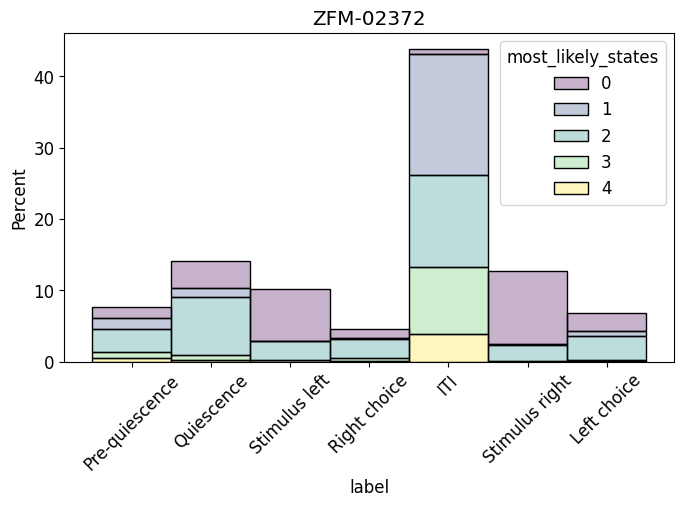

In [21]:
        """ Plot states per trial epoch """
        colors = sns.color_palette("viridis", 5)
        # states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
        # states_trial = states_per_trial_phase(empirical_data, cont_trials, multiplier)
        plt.figure(figsize=[7, 5])
        sns.histplot(x='label', hue='most_likely_states', data=states_trial, stat = 'percent',
                            multiple="stack", legend=True, palette='viridis', alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.title(mouse_name)
        plt.show()
        
        # plot_states_trial_type(states_trial)